In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import functional as F
import torchvision

from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor
Tensor = TypeVar('torch.tensor')
from PIL import Image  
import os

device = torch.device("cuda:0")

import datetime
# 定义vae模型
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_CNN, self).__init__()
        self.latent_dim = latent_dim
        in_channels = 3

        hidden_dims = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']  # VGG11结构

        # 构建编码器
        self.encoder = self.make_layers(hidden_dims, in_channels)
        self.fc_mu = nn.Linear(hidden_dims[-2], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-2], latent_dim)

        # kjl多加一个类别层
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 10),
        )
        
        # 初始化权重
        self._initialize_weights()

    # 权重初始化
    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    # 来自vgg
    def make_layers(self, cfg, in_channels, batch_norm: bool = True) -> nn.Sequential:
        layers: List[nn.Module] = []
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def encode(self, input):
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        class_info = self.classifier(result) # 类别信息
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var, class_info

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu



    def forward(self, input, **kwargs):
        mu, log_var, class_info = self.encode(input)
        return mu, log_var, class_info

# 官方的vae损失
def vae_loss_official(mu, logvar, class_info, label, device, kl_weight, cl_weight):
    class_loss_fn = nn.CrossEntropyLoss()

    cl_loss = class_loss_fn(class_info, label) # 类别损失
    kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0) # kl损失
    loss = kl_weight * kl_loss + cl_weight * cl_loss
    return loss

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])


# 设置训练参数
latent_dim = 2
batch_size = 128
epochs = 300
lr = 0.005
kl_weight = 0.00005
cl_weight = 0.5

# 加载数据集
train_dataset = torchvision.datasets.CIFAR10(root='./static/data/CIFAR10/CIFAR10/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

# 初始化VAE模型和优化器
vae = VAE_CNN(latent_dim)
vae = vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

# 训练VAE模型
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (x, label) in enumerate(train_loader):
        if batch_idx == 0:
            labels = label
        else:
            labels = torch.cat((labels, label), dim=0)

        optimizer.zero_grad()

        x = x.to(device)
        label = label.to(device)
        mu, logvar, class_info = vae(x)

        loss = vae_loss_official(mu, logvar, class_info, label, device, kl_weight, cl_weight)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader.dataset)}")

print(labels.shape)

# 关键参数信息
title = "epoch = " + str(epochs) + " kl = " + str(kl_weight) + " cl = " + str(cl_weight) + " loss = " + str(total_loss / len(train_loader.dataset)) + " batch_size = " + str(batch_size) + " VAE-deep-class-norecon"

time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
torch.save(vae.state_dict(), "./临时垃圾-随时可删/20230825vae带卷积训练/vae_state_dict_"+ title + " " + time + ".pt")

Files already downloaded and verified
Epoch 1/300, Loss: 0.007848023973703384
Epoch 2/300, Loss: 0.007285138759613037
Epoch 3/300, Loss: 0.006887036365270615
Epoch 4/300, Loss: 0.006389304151535034
Epoch 5/300, Loss: 0.005971772255897522
Epoch 6/300, Loss: 0.005498274849653244
Epoch 7/300, Loss: 0.004989272359609604
Epoch 8/300, Loss: 0.004437123011350632
Epoch 9/300, Loss: 0.004004202890992165
Epoch 10/300, Loss: 0.0036604704016447065
Epoch 11/300, Loss: 0.0033411808168888092
Epoch 12/300, Loss: 0.0030441989961266518
Epoch 13/300, Loss: 0.002761743739545345
Epoch 14/300, Loss: 0.0024904676392674447
Epoch 15/300, Loss: 0.0023193488049507143
Epoch 16/300, Loss: 0.0020843658386170863
Epoch 17/300, Loss: 0.0019034968966245651
Epoch 18/300, Loss: 0.0017171411646902562
Epoch 19/300, Loss: 0.0016024273420870304
Epoch 20/300, Loss: 0.0014503593964874744
Epoch 21/300, Loss: 0.0013095019879937172
Epoch 22/300, Loss: 0.001218258086591959
Epoch 23/300, Loss: 0.0011744601874798537
Epoch 24/300, Lo

In [2]:
# 降维
# vae = VAE_CNN(2)
# vae_path = "./临时垃圾-随时可删/20230825vae带卷积训练/vae_state_dict_epoch = 200 kl = 5e-05 loss = 0.004508875371217727 batch_size = 128 VAE-deep 2023-08-26 14:09:00.pt"
# title = "vae_state_dict_epoch = 200 kl = 5e-05 loss = 0.004508875371217727 batch_size = 128 VAE-deep 2023-08-26 14:09:00.pt"
# vae.load_state_dict(torch.load(vae_path, map_location=device))
# vae = vae.to(torch.device("cuda:0"))

vae.eval()
# 加载数据集
# train_dataset = Mydata_sets('./static/data/CIFAR10/pic/random_50k_png', transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for batch_idx, (x, id_number) in enumerate(train_loader):
        x = x.to(device)
        mu, log_var, class_info = vae.encode(x)

        if batch_idx == 0:
           _, pre_types = torch.max(class_info.data, 1)
        else:
            _, pre_type = torch.max(class_info.data, 1)
            pre_types = torch.cat((pre_types, pre_type), dim=0)

        z = vae.reparameterize(mu, log_var)
        if batch_idx == 0:
            zs = z
        else:
            zs = torch.cat((zs, z), dim=0)
            
print("zs.shape: ", zs.shape)
print("pre_types.shape: ", pre_types.shape)

zs.shape:  torch.Size([50000, 2])
pre_types.shape:  torch.Size([50000])


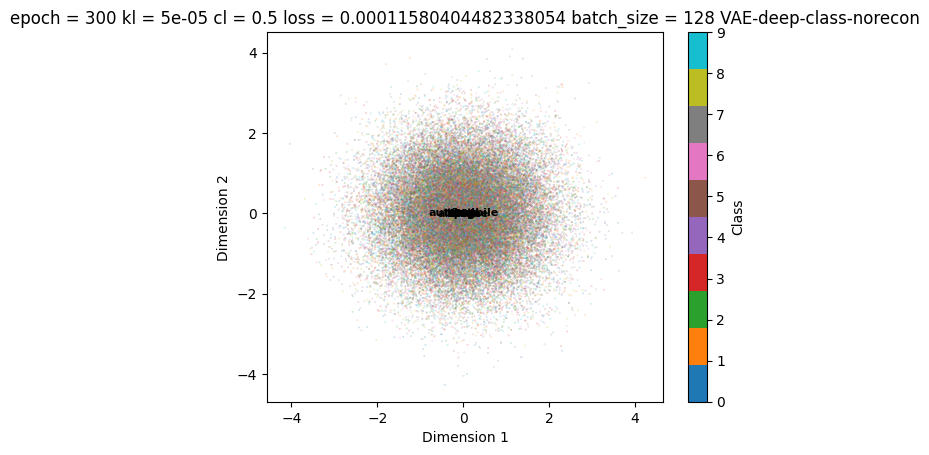

In [3]:
# 绘制散点图

import torch
import numpy as np
import matplotlib.pyplot as plt

# labels = torch.load("./临时垃圾-随时可删/labels.pt")
cifar10_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# 将张量转换为 NumPy 数组
zs_np = zs.to(torch.device("cpu")).detach().numpy()
# zs_np = zs_np[:5000]
# labels = labels[:5000]

# 获取类别数量和颜色映射
color_map = plt.get_cmap("tab10")

# 绘制散点图
plt.scatter(zs_np[:, 0], zs_np[:, 1], s=0.01, c=labels, cmap=color_map)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title(title)
plt.colorbar(label="Class")

# 添加类别标签
for i in range(10):
    label = cifar10_labels[i]
    x = zs_np[labels == i, 0].mean()
    y = zs_np[labels == i, 1].mean()
    plt.text(x, y, label, fontsize=8, ha='center', va='center', weight='bold')
plt.show()

In [4]:
cifar10_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

for i in range(32):
    print(f"真实标签 = {cifar10_labels[labels[i]]}, 预测标签 = {cifar10_labels[pre_types[i]]}")

真实标签 = frog, 预测标签 = frog
真实标签 = truck, 预测标签 = truck
真实标签 = truck, 预测标签 = truck
真实标签 = deer, 预测标签 = deer
真实标签 = automobile, 预测标签 = automobile
真实标签 = automobile, 预测标签 = automobile
真实标签 = bird, 预测标签 = bird
真实标签 = horse, 预测标签 = horse
真实标签 = ship, 预测标签 = ship
真实标签 = cat, 预测标签 = cat
真实标签 = deer, 预测标签 = deer
真实标签 = horse, 预测标签 = horse
真实标签 = horse, 预测标签 = horse
真实标签 = bird, 预测标签 = bird
真实标签 = truck, 预测标签 = truck
真实标签 = truck, 预测标签 = truck
真实标签 = truck, 预测标签 = truck
真实标签 = cat, 预测标签 = cat
真实标签 = bird, 预测标签 = bird
真实标签 = frog, 预测标签 = frog
真实标签 = deer, 预测标签 = deer
真实标签 = cat, 预测标签 = cat
真实标签 = frog, 预测标签 = frog
真实标签 = frog, 预测标签 = frog
真实标签 = bird, 预测标签 = bird
真实标签 = frog, 预测标签 = frog
真实标签 = cat, 预测标签 = cat
真实标签 = dog, 预测标签 = dog
真实标签 = deer, 预测标签 = deer
真实标签 = airplane, 预测标签 = airplane
真实标签 = airplane, 预测标签 = airplane
真实标签 = truck, 预测标签 = truck
